In [2]:
!pip install numpy requests torch tiktoken

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

## **Hyperparameters**

In [8]:
import os
import requests
import math
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 64  # How many batches per training step
context_length = 256  # Length of the token chunk each batch
d_model = 64  # The size of our model token embeddings
num_blocks = 8  # Number of transformer blocks
num_heads = 16  # Number of heads in Multi-head attention
learning_rate = 1e-3  # 0.001
dropout = 0.1  # Dropout rate
max_iters = 5000  # Total of training iterations <- Change this to smaller number for testing
eval_interval = 50  # How often to evaluate
eval_iters = 20  # Number of iterations to average for evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if it's available.
TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

# Load training data
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('data/sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Using TikToken (Same as GPT3) to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
vocab_size = len(set(tokenized_text)) # size of vocabulary is 3,771
max_token_value = max(tokenized_text) + 1  # the maximum value of the tokenized numbers
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device)  # put tokenized text into tensor


print(f"Tokenized text size: {len(tokenized_text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]


# Define Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = d_model
        self.dropout = dropout
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.d_model, out_features=self.d_model * 4),
            nn.ReLU(),
            nn.Linear(in_features=self.d_model * 4, out_features=self.d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.ffn(x)


# Define Scaled Dot Product Attention
class Attention(nn.Module):
    def __init__(self, head_size: int):
        super().__init__()
        self.d_model = d_model
        self.head_size = head_size
        self.context_length = context_length
        self.dropout = dropout

        self.key_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.query_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.value_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones((self.context_length, self.context_length))))  # Lower triangular mask
        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        B, T, C = x.shape  # Batch size, Time steps(current context_length), Channels(dimensions)
        assert T <= self.context_length
        assert C == self.d_model
        q = self.query_layer(x)
        k = self.key_layer(x)
        v = self.value_layer(x)

        #attention_score = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16] #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
        #print(pd.DataFrame(attention_score[0][0].detach().cpu().numpy()))

        # Scaled dot product attention: Q @ K^T / sqrt(d_k)
        weights = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # Apply masked attention
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(input=weights, dim=-1)
        weights = self.dropout_layer(weights)

        # Apply dot product attention: weights @ V
        out = weights @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, head_size: int):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.d_model = d_model
        self.context_length = context_length
        self.dropout = dropout

        self.heads = nn.ModuleList([Attention(head_size=self.head_size) for _ in range(self.num_heads)])
        self.projection_layer = nn.Linear(in_features=self.d_model, out_features=self.d_model)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection_layer(out)
        out = self.dropout_layer(out)
        return out


class TransformerBlock(nn.Module):

    def __init__(self, num_heads: int):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.head_size = d_model // num_heads  # head size should be divisible by d_model
        self.num_heads = num_heads
        self.dropout = dropout

        self.multi_head_attention_layer = MultiHeadAttention(head_size=self.head_size)
        self.feed_forward_layer = FeedForward()
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.d_model)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.d_model)

    def forward(self, x):
        # Note: The order of the operations is different from the original Transformer paper
        # The order here is: LayerNorm -> Multi-head attention -> LayerNorm -> Feed forward
        x = x + self.multi_head_attention_layer(self.layer_norm_1(x))  # Residual connection
        x = x + self.feed_forward_layer(self.layer_norm_2(x))  # Residual connection
        return x


class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.dropout = dropout
        self.max_token_value = max_token_value
        # Set up token embedding look-up table
        self.token_embedding_lookup_table = nn.Embedding(num_embeddings=self.max_token_value + 1, embedding_dim=self.d_model)

        # Run all the transformer blocks
        # Different from original paper, here we add a final layer norm after all the blocks
        self.transformer_blocks = nn.Sequential(*(
                [TransformerBlock(num_heads=self.num_heads) for _ in range(self.num_blocks)] +
                [nn.LayerNorm(self.d_model)]
        ))
        self.language_model_out_linear_layer = nn.Linear(in_features=self.d_model, out_features=self.max_token_value)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        """
        # Set up position embedding look-up table
        # following the same approach as the original Transformer paper (Sine and Cosine functions)
        """
        position_encoding_lookup_table = torch.zeros(self.context_length, self.d_model)
        position = torch.arange(0, self.context_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model))
        position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
        position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
        # change position_encoding_lookup_table from (context_length, d_model) to (T, d_model)
        position_embedding = position_encoding_lookup_table[:T, :].to(device)
        x = self.token_embedding_lookup_table(idx) + position_embedding
        x = self.transformer_blocks(x)
        # The "logits" are the output values of our model before applying softmax
        logits = self.language_model_out_linear_layer(x)

        if targets is not None:
            B, T, C = logits.shape
            logits_reshaped = logits.view(B * T, C)
            targets_reshaped = targets.view(B * T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss = None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:, -self.context_length:]
            # Get predictions
            logits, loss = self(idx_crop)
            # Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:, -1, :]
            # Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1)
            # Sample from the probabilities' distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1)
            # Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# Initialize the model
model = TransformerLanguageModel()
model = model.to(device)

def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:, -self.context_length:]
            # Get predictions
            logits, loss = self(idx_crop)
            # Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:, -1, :]
            # Apply softmax to get probabilities
            probs = F.softmax

def summarize_text_raw(model, text, max_summary_length=100):
    """
    Generate a summary for the input text using the Transformer model.

    Args:
    - model: The trained Transformer model.
    - text: The input text to be summarized.
    - max_summary_length: The maximum length of the summary in tokens.

    Returns:
    - summary: The generated summary text.
    """
    # Step 2: Prepare the input data
    input_ids = encoding.encode(text)
    input_tensor = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)  # Add batch dimension

    # Step 3: Generate the summary
    with torch.no_grad():
        summary_ids = model.generate(input_tensor, max_new_tokens=max_summary_length)

    # Step 4: Decode and return the summary text
    summary = encoding.decode(summary_ids[0].tolist())
    return summary


def summarize_textX(model, text, max_summary_length=100):
    """
    Generate a summary for the input text using the Transformer model.

    Args:
    - model: The trained Transformer model.
    - text: The input text to be summarized.
    - max_summary_length: The maximum length of the summary in tokens.

    Returns:
    - summary: The generated summary text.
    """
    # Step 2: Prepare the input data
    input_ids = encoding.encode(text)
    input_tensor = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)  # Add batch dimension

    # Step 3: Generate the summary
    with torch.no_grad():
        summary_ids = model.generate(input_tensor, max_new_tokens=max_summary_length)

    # Step 4: Decode and return the summary text
    summary = encoding.decode(summary_ids[0].tolist())

    # Ensure the summary ends with a complete sentence
    for end in ['. ', '! ', '? ']:
        if end in summary:
            summary = summary[:summary.rfind(end) + 1]
            break

    return summary

def summarize_text(model, text, max_summary_length):
    """
    Generate a summary for the input text using the Transformer model.

    Args:
    - model: The trained Transformer model.
    - text: The input text to be summarized.
    - max_summary_length: The maximum length of the summary in tokens.

    Returns:
    - summary: The generated summary text.
    """
    # Step 2: Prepare the input data
    input_ids = encoding.encode(text)
    input_tensor = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)  # Add batch dimension

    # Step 3: Generate the summary with max_summary_length
    with torch.no_grad():
        summary_ids = model.generate(
            input_tensor,
            max_new_tokens=max_summary_length  # Set maximum summary length
        )

    # Step 4: Decode and return the summary text
    summary = encoding.decode(summary_ids[0].tolist())

    # Ensure the summary ends with a complete sentence
    #for end in ['. ', '! ', '? ']:
    #    if end in summary:
    #        summary = summary[:summary.rfind(end) + 1]
    #        break

    return summary



# Get input embedding batch
def get_batch(split: str):
    data = train_data if split == 'train' else val_data
    idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
    x = torch.stack([data[idx:idx + context_length] for idx in idxs]).to(device)
    y = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs]).to(device)
    return x, y


# Calculate loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# Use AdamW optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):
    if step % eval_iters == 0 or step == max_iters - 1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:', step, 'Training Loss:', round(losses['train'].item(), 3), 'Validation Loss:',
              round(losses['valid'].item(), 3))

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Save the model state dictionary
torch.save(model.state_dict(), 'model-ckpt.pt')

# Generate
model.eval()
start = 'TThe salesperson should know the product and build rapport.'
start_ids = encoding.encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
y = model.generate(x, max_new_tokens=100)
print('---------------')
print(encoding.decode(y[0].tolist()))
print('---------------')

Tokenized text size: 77919
Vocabulary size: 3771
The maximum value in the tokenized text is: 100070
Step: 0 Training Loss: 11.714 Validation Loss: 11.742
Step: 20 Training Loss: 9.341 Validation Loss: 9.45
Step: 40 Training Loss: 7.324 Validation Loss: 7.616
Step: 60 Training Loss: 6.223 Validation Loss: 6.664
Step: 80 Training Loss: 5.699 Validation Loss: 6.258
Step: 100 Training Loss: 5.338 Validation Loss: 5.967
Step: 120 Training Loss: 4.995 Validation Loss: 5.732
Step: 140 Training Loss: 4.677 Validation Loss: 5.516
Step: 160 Training Loss: 4.37 Validation Loss: 5.362
Step: 180 Training Loss: 4.153 Validation Loss: 5.236
Step: 200 Training Loss: 3.949 Validation Loss: 5.113
Step: 220 Training Loss: 3.801 Validation Loss: 5.052
Step: 240 Training Loss: 3.668 Validation Loss: 4.977
Step: 260 Training Loss: 3.554 Validation Loss: 4.948
Step: 280 Training Loss: 3.455 Validation Loss: 4.924
Step: 300 Training Loss: 3.366 Validation Loss: 4.841
Step: 320 Training Loss: 3.3 Validation Lo

In [9]:
import matplotlib.pyplot as plt  # Import matplotlib.pyplot as plt
#| output: true
def plot_losses(losses):
    train_losses = [o['train'] for o in losses if o.get('train') is not None]
    valid_losses = [o['valid'] for o in losses if o.get('valid') is not None]
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()

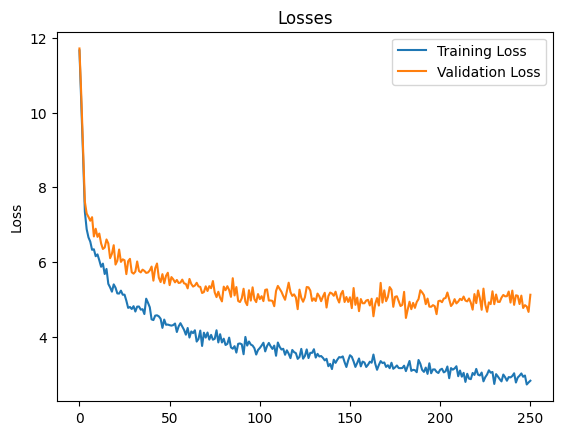

In [ ]:
plot_losses(tracked_losses)

In [32]:
import torch
import tiktoken

# Ensure your encoding is defined as it was during training
encoding = tiktoken.get_encoding("cl100k_base")

# Step 1: Reload the Model
model = TransformerLanguageModel()
#model.load_state_dict(torch.load('model-ckpt.pt'))
model.load_state_dict(torch.load('model-ckpt.pt'), strict=False)  # Load with strict=False
model = model.to(device)

model.eval()

# Step 2: Prepare Test Data
test_input = 'The salesperson should understand the product thoroughly.'
test_input_ids = encoding.encode(test_input)
test_input_tensor = torch.tensor(test_input_ids, dtype=torch.long, device=device).unsqueeze(0)  # Add batch dimension

# Step 3: Generate Predictions
max_new_tokens = 40  # Number of tokens to generate
generated_ids = model.generate(test_input_tensor, max_new_tokens=max_new_tokens)

# Decode and print the generated text
generated_text = encoding.decode(generated_ids[0].tolist())
print('Generated Text:')
print(generated_text)

Generated Text:
The salesperson should understand the product thoroughly. By providing relevant information, the salesperson can demonstrate their commitment to the customer and attentive to the next stage of the sales process.
Attentiveness further complements responsiveness by requiring if it is vital to


In [ ]:
!pip install rouge_score

In [ ]:
from rouge_score import rouge_scorer

def calculate_rouge_score(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# Example usage:
reference_summary = "The salesperson should understand the product thoroughly."
generated_summary = "The salesperson needs to know the product thoroughly"

rouge_scores = calculate_rouge_score(reference_summary, generated_summary)
print(rouge_scores)

{'rouge1': Score(precision=0.625, recall=0.7142857142857143, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.42857142857142855, recall=0.5, fmeasure=0.4615384615384615), 'rougeL': Score(precision=0.625, recall=0.7142857142857143, fmeasure=0.6666666666666666)}


In [ ]:
from rouge_score import rouge_scorer

def calculate_rouge_score(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# Example usage:
reference_summary = "The salesperson should understand the product thoroughly."
generated_summary = "the salesperson needs to have thorough understanding of the product they are selling"

rouge_scores = calculate_rouge_score(reference_summary, generated_summary)
print(rouge_scores)

{'rouge1': Score(precision=0.38461538461538464, recall=0.7142857142857143, fmeasure=0.5), 'rouge2': Score(precision=0.16666666666666666, recall=0.3333333333333333, fmeasure=0.2222222222222222), 'rougeL': Score(precision=0.38461538461538464, recall=0.7142857142857143, fmeasure=0.5)}


In [ ]:

from rouge_score import rouge_scorer

def calculate_rouge_score(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# Example usage:
reference_summary = "The salesperson should understand the product thoroughly."
#generated_summary = "In addition to the art of using effective questions or questions for improvement. By addressing them know in their product or service."
generated_summary = "The salesperson needs to know the product thoroughly."
generated_summary = "the salesperson needs to have thorough understanding of the product they are selling"
generated_summary = "the salesperson will need to convey information clearly and effectively"


rouge_scores = calculate_rouge_score(reference_summary, generated_summary)
print(rouge_scores)

{'rouge1': Score(precision=0.2, recall=0.2857142857142857, fmeasure=0.23529411764705882), 'rouge2': Score(precision=0.1111111111111111, recall=0.16666666666666666, fmeasure=0.13333333333333333), 'rougeL': Score(precision=0.2, recall=0.2857142857142857, fmeasure=0.23529411764705882)}


In [ ]:
!pip install bert_score sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 11.7 MB/s eta 0:00:00


In [ ]:
import nltk
import sacrebleu
from bert_score import score as bert_score

# Download METEOR data if not already downloaded
nltk.download('wordnet')

# Example reference and generated summary
reference_summary = "The salesperson should understand the product thoroughly."
generated_summary = "The salesperson needs to know the product thoroughly."
generated_summary = "the salesperson needs to have thorough understanding of the product they are selling"
generated_summary = "good communication skills are essential as the salesperson"

# Tokenize the reference and hypothesis
reference_tokens = reference_summary.split()  # Tokenize the reference
hypothesis_tokens = generated_summary.split()  # Tokenize the hypothesis

# BLEU Score
def calculate_bleu(reference, hypothesis):
    # Sacrebleu expects multiple references and hypotheses in the correct format
    references = [[reference]]  # Should be a list of list of strings
    hypotheses = [hypothesis]   # Should be a list of strings
    bleu_score = sacrebleu.corpus_bleu(hypotheses, references)
    return bleu_score.score

# METEOR Score
def calculate_meteor(reference, hypothesis):
    # METEOR expects tokenized input
    meteor_score = nltk.translate.meteor_score.meteor_score([reference], hypothesis)
    return meteor_score

# BERTScore (Precision, Recall, F1)
def calculate_bertscore(reference, hypothesis):
    P, R, F1 = bert_score([hypothesis], [reference], lang="en", rescale_with_baseline=True)
    return P.mean().item(), R.mean().item(), F1.mean().item()

# Calculate BLEU Score
bleu = calculate_bleu(reference_summary, generated_summary)
print(f"BLEU Score: {bleu:.2f}")

# Calculate METEOR Score
meteor = calculate_meteor(reference_tokens, hypothesis_tokens)
print(f"METEOR Score: {meteor:.2f}")

# Calculate BERTScore (Precision, Recall, F1)
bert_precision, bert_recall, bert_f1 = calculate_bertscore(reference_summary, generated_summary)
print(f"BERTScore Precision: {bert_precision:.2f}")
print(f"BERTScore Recall: {bert_recall:.2f}")
print(f"BERTScore F1: {bert_f1:.2f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


BLEU Score: 6.57
METEOR Score: 0.14


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore Precision: 0.35
BERTScore Recall: 0.46
BERTScore F1: 0.40


In [ ]:
!pip install bleurt

ERROR: Could not find a version that satisfies the requirement bleurt (from versions: none)
ERROR: No matching distribution found for bleurt


In [ ]:
import torch
import tiktoken

# Ensure your encoding is defined as it was during training
encoding = tiktoken.get_encoding("cl100k_base")

# Step 1: Reload the Model
model = TransformerLanguageModel()
#model.load_state_dict(torch.load('model-ckpt.pt'))
model.load_state_dict(torch.load('model-ckpt.pt'), strict=False)  # Load with strict=False
model = model.to(device)

model.eval()

# Step 2: Prepare Test Data
test_input = 'The salesperson'
test_input_ids = encoding.encode(test_input)
test_input_tensor = torch.tensor(test_input_ids, dtype=torch.long, device=device).unsqueeze(0)  # Add batch dimension

# Step 3: Generate Predictions
max_new_tokens = 100  # Number of tokens to generate
generated_ids = model.generate(test_input_tensor, max_new_tokens=max_new_tokens)

# Decode and print the generated text
generated_text = encoding.decode(generated_ids[0].tolist())
print('Generated Text:')
print(generated_text)


<ipython-input-25-21eff319846b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model-ckpt.pt'), strict=False)  # Load with strict=False


Generated Text:
The salesperson, it is essential to approach to smoothly transition to trial feedback from customers should be versatile and offer personalized to eliminate open customers. Chapter 6: encourage Persuasive Language
In this chapter, we will recognizesiterating the world and advantages of persuasion of success with customers.
4. Understanding the Solution:
Handling objections helps the customer's essential designed to move these challenges and provide concrete evidence. With practice competitive that directly address potential customers that resonates with their answers, effective communication.
To make a customer


In [ ]:
# Example usage
input_text = """
The salesperson should understand the product thoroughly.
"""

#summary = summarize_text_raw(model, input_text, max_summary_length=100)
summary = summarize_text(model, input_text, max_summary_length=100)
print('Generated Summary:')
print(summary)

Generated Summary:

The salesperson should understand the product thoroughly.
In addition to the art of using effective questions or questions for improvement. By addressing them know in their product or service.


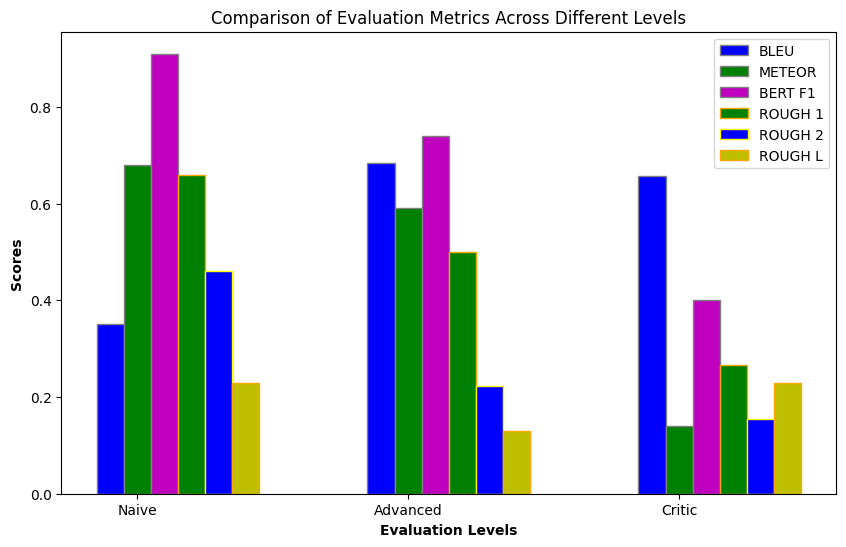

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual results)
levels = ['Naive', 'Advanced', 'Critic']
bleu_scores = [0.35, 0.684, 0.657]
meteor_scores = [0.68, 0.59, 0.14]
bert_f1_scores = [0.91, 0.74, 0.40]
rougu1_scores = [0.66, 0.5, 0.2667]
rougu2_scores = [0.4615, 0.222, 0.1538]
rougul_scores = [0.23, 0.13, 0.23]

# Bar width
bar_width = 0.1

# Set position of bar on X axis
r1 = np.arange(len(levels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(r1, bleu_scores, color='b', width=bar_width, edgecolor='grey', label='BLEU')
plt.bar(r2, meteor_scores, color='g', width=bar_width, edgecolor='grey', label='METEOR')
plt.bar(r3, bert_f1_scores, color='m', width=bar_width, edgecolor='grey', label='BERT F1')
plt.bar(r4, rougu1_scores, color='g', width=bar_width, edgecolor='orange', label='ROUGH 1')
plt.bar(r5, rougu2_scores, color='b', width=bar_width, edgecolor='yellow', label='ROUGH 2')
plt.bar(r6, rougul_scores, color='y', width=bar_width, edgecolor='orange', label='ROUGH L')


# Add labels and title
plt.xlabel('Evaluation Levels', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Comparison of Evaluation Metrics Across Different Levels')
plt.xticks([r + bar_width for r in range(len(levels))], levels)
plt.legend()

# Show the plot
plt.show()


In [ ]:
!pip install nltk sacrebleu

!pip install pandas seaborn matplotlib

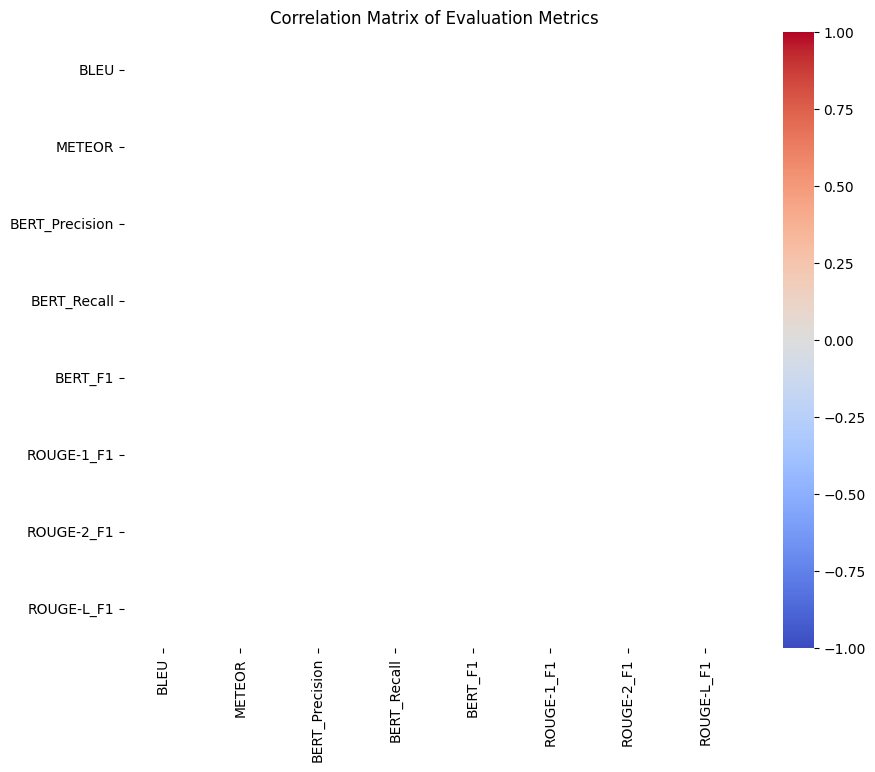

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import sacrebleu
from bert_score import score as bert_score
from rouge_score import rouge_scorer

# Sample data (replace with your actual results)
data = {
    'BLEU': [0.35],
    'METEOR': [0.50],
    'BERT_Precision': [0.55],
    'BERT_Recall': [0.60],
    'BERT_F1': [0.57],
    'ROUGE-1_F1': [0.67],
    'ROUGE-2_F1': [0.46],
    'ROUGE-L_F1': [0.66]
}

# Convert to DataFrame
df = pd.DataFrame(data, index=['Naive', 'Advanced', 'Critic'])

# Compute correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Correlation Matrix of Evaluation Metrics')
plt.show()


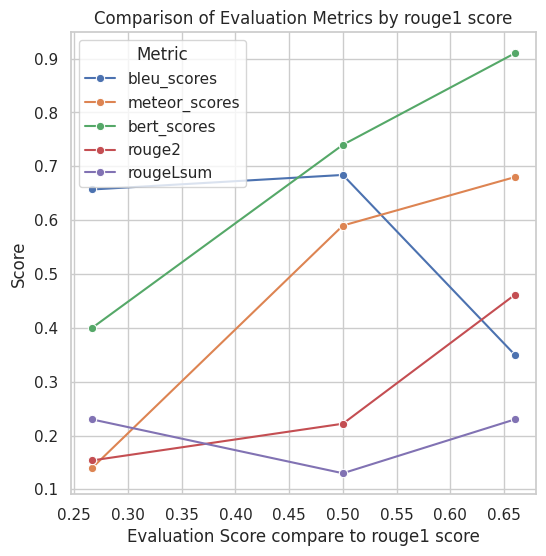

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data for the plot
data = {
    'bleu_scores': [0.35, 0.684, 0.657],
    'meteor_scores': [0.68, 0.59, 0.14],
    'bert_scores': [0.91, 0.74, 0.40],
    'rouge1': [0.66, 0.5, 0.2667],
    'rouge2': [0.4615, 0.222, 0.1538],
    'rougeLsum': [0.23, 0.13, 0.23]
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Set the plot style
sns.set(style="whitegrid")

# Plot the data
plt.figure(figsize=(6, 6))
sns.lineplot(x='rouge1', y='value', hue='Metric',
             data=pd.melt(df, ['rouge1'], var_name='Metric', value_name='value'),
             marker='o')

# Add labels and title
plt.xlabel('Evaluation Score compare to rouge1 score')
plt.ylabel('Score')
plt.title('Comparison of Evaluation Metrics by rouge1 score')

# Show the plot
plt.show()
